In [1]:
import os
import cv2
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
print(os.getcwd())

/kaggle/working


In [8]:
files = ['banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible','chicken - edible', 'chicken - inedible',
         'donut - edible','donut - inedible','mango - edible', 'mango - inedible', 'pizza - edible','pizza - inedible', 'rice - edible', 'rice - inedible']
file_path = "/kaggle/input/foodition-dataset/dataset/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)
        if i.endswith('.jpeg'):
            data[col].append(i)


In [9]:
data_count = {key: len(value) for key, value in data.items()}
total_data_count = sum(data_count.values())
print(data_count)


{'banana - edible': 513, 'banana - inedible': 600, 'bread - edible': 742, 'bread - inedible': 482, 'chicken - edible': 531, 'chicken - inedible': 540, 'donut - edible': 708, 'donut - inedible': 526, 'mango - edible': 542, 'mango - inedible': 544, 'pizza - edible': 426, 'pizza - inedible': 560, 'rice - edible': 593, 'rice - inedible': 558}


In [11]:
sample_size = total_data_count
width = 160
height = 160

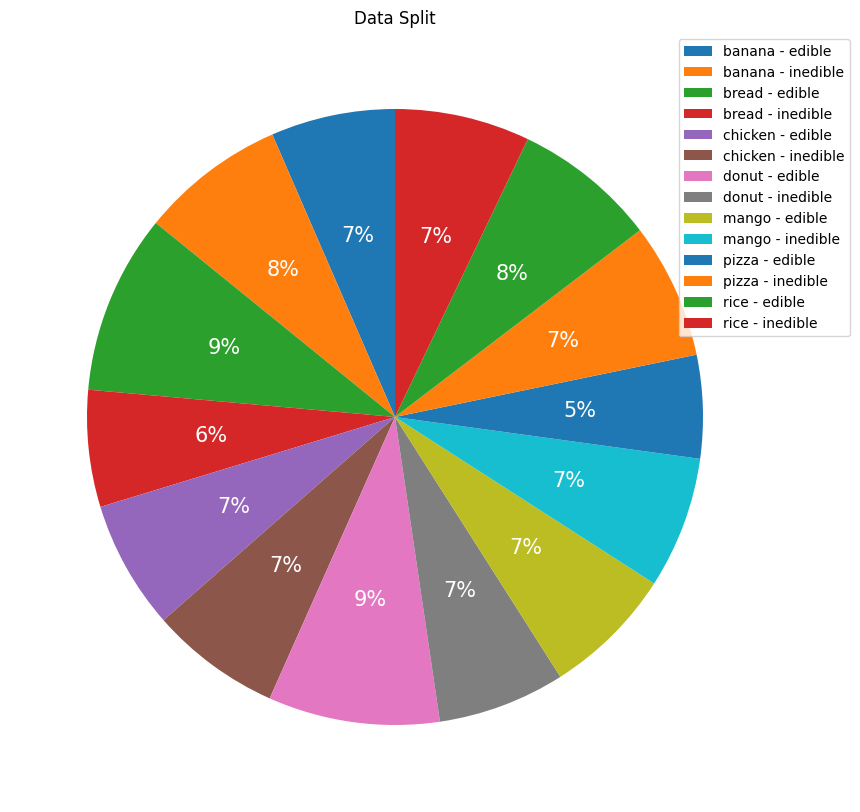

In [12]:
sizes = [len(data['banana - edible']), len(data['banana - inedible']), len(data['bread - edible']), len(data['bread - inedible']), len(data['chicken - edible']), len(data['chicken - inedible']),
         len(data['donut - edible']), len(data['donut - inedible']), len(data['mango - edible']), len(data['mango - inedible']), len(data['pizza - edible']), len(data['pizza - inedible']),
         len(data['rice - edible']), len(data['rice - inedible'])]


plt.figure(figsize=(10, 10), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [13]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    image_batch = []
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_batch.append(cv2.resize(img, (width, height)))
    image_data.extend(image_batch[:sample_size])
    image_target.extend([title] * min(len(image_batch), sample_size))
    clear_output(wait=True)
    print("Compiled Class", title)

calculate_time = time.time() - start
print("Calculate Time", round(calculate_time, 5))


Compiled Class rice - inedible
Calculate Time 74.52102


In [15]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(7865, 160, 160, 3)

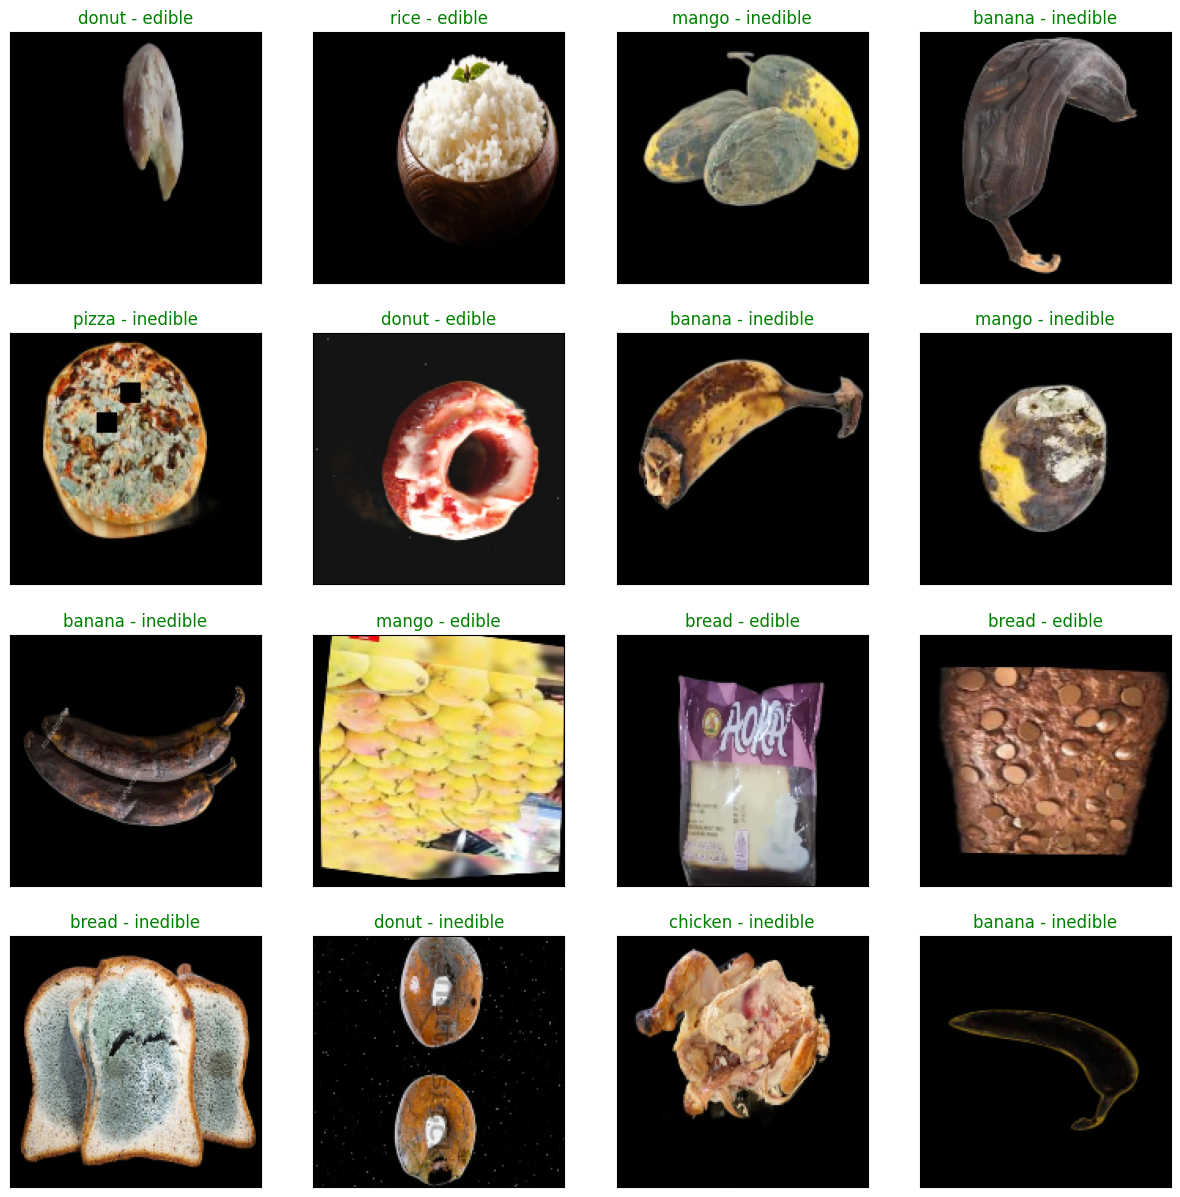

In [16]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if 'edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [18]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(14, activation='softmax')
])

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=3,
                                                restore_best_weights=True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

history = model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/25
173/173 [==============================] - 14s 50ms/step - loss: 1.1832 - accuracy: 0.6205 - categorical_accuracy: 0.0763 - val_loss: 0.3365 - val_accuracy: 0.9093 - val_categorical_accuracy: 0.0627 - lr: 0.0010
Epoch 2/25
173/173 [==============================] - 5s 28ms/step - loss: 0.4549 - accuracy: 0.8570 - categorical_accuracy: 0.0663 - val_loss: 0.1892 - val_accuracy: 0.9466 - val_categorical_accuracy: 0.0631 - lr: 9.0484e-04
Epoch 3/25
173/173 [==============================] - 5s 28ms/step - loss: 0.3106 - accuracy: 0.9032 - categorical_accuracy: 0.0663 - val_loss: 0.1268 - val_accuracy: 0.9589 - val_categorical_accuracy: 0.0631 - lr: 8.1873e-04
Epoch 4/25
173/173 [==============================] - 5s 28ms/step - loss: 0.2347 - accuracy: 0.9261 - categorical_accuracy: 0.0668 - val_loss: 0.1205 - val_accuracy: 0.9610 - val_categorical_accuracy: 0.0631 - lr: 7.4082e-04
Epoch 5/25
173/173 [==============================] - 5s 28ms/step - loss: 0.1959 - accuracy: 0.941

74/74 - 1s - loss: 0.0519 - accuracy: 0.9856 - categorical_accuracy: 0.0640 - 1s/epoch - 18ms/step


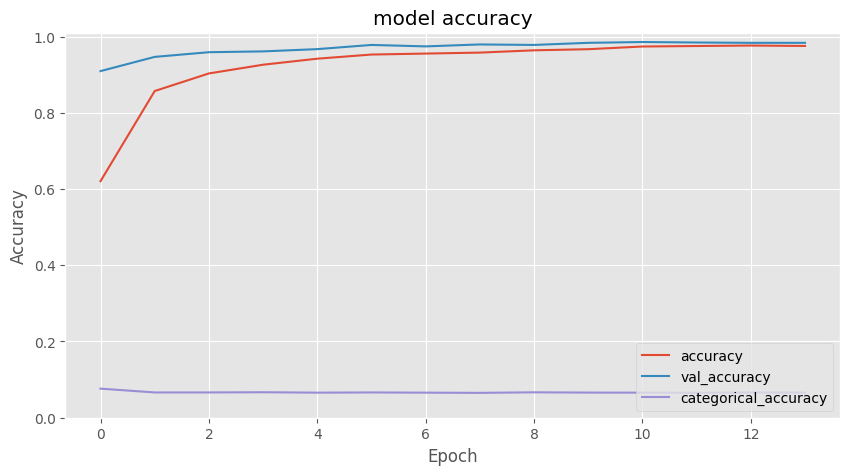

In [25]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

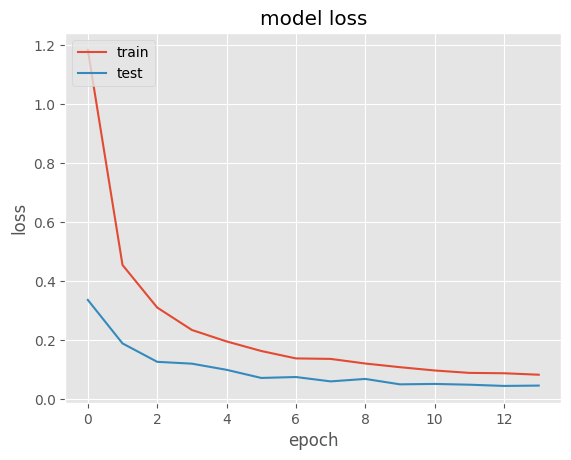

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

74/74 [==============================] - 2s 18ms/step


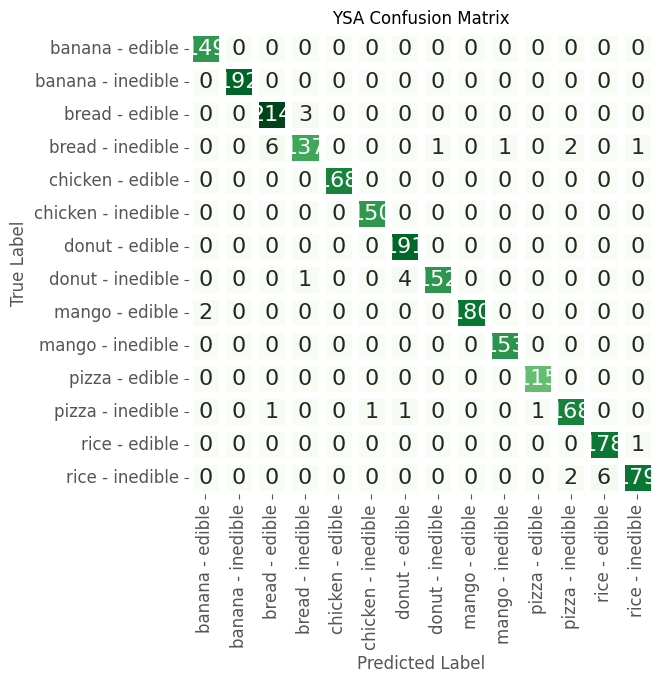

In [27]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=['banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible', 'donut - edible','donut - inedible', 'mango - edible', 'mango - inedible', 'pizza - edible','pizza - inedible', 'rice - edible', 'rice - inedible'],
                   index= ['banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible', 'donut - edible','donut - inedible', 'mango - edible', 'mango - inedible', 'pizza - edible','pizza - inedible', 'rice - edible', 'rice - inedible'], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [28]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.986144


In [29]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.985528


In [30]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.985727


In [31]:
def Prediction(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0

    class_list = ['banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible',
                  'donut - edible','donut - inedible', 'mango - edible', 'mango - inedible', 'pizza - edible','pizza - inedible', 'rice - edible', 'rice - inedible']

    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

1/1 [==============================] - 0s 21ms/step


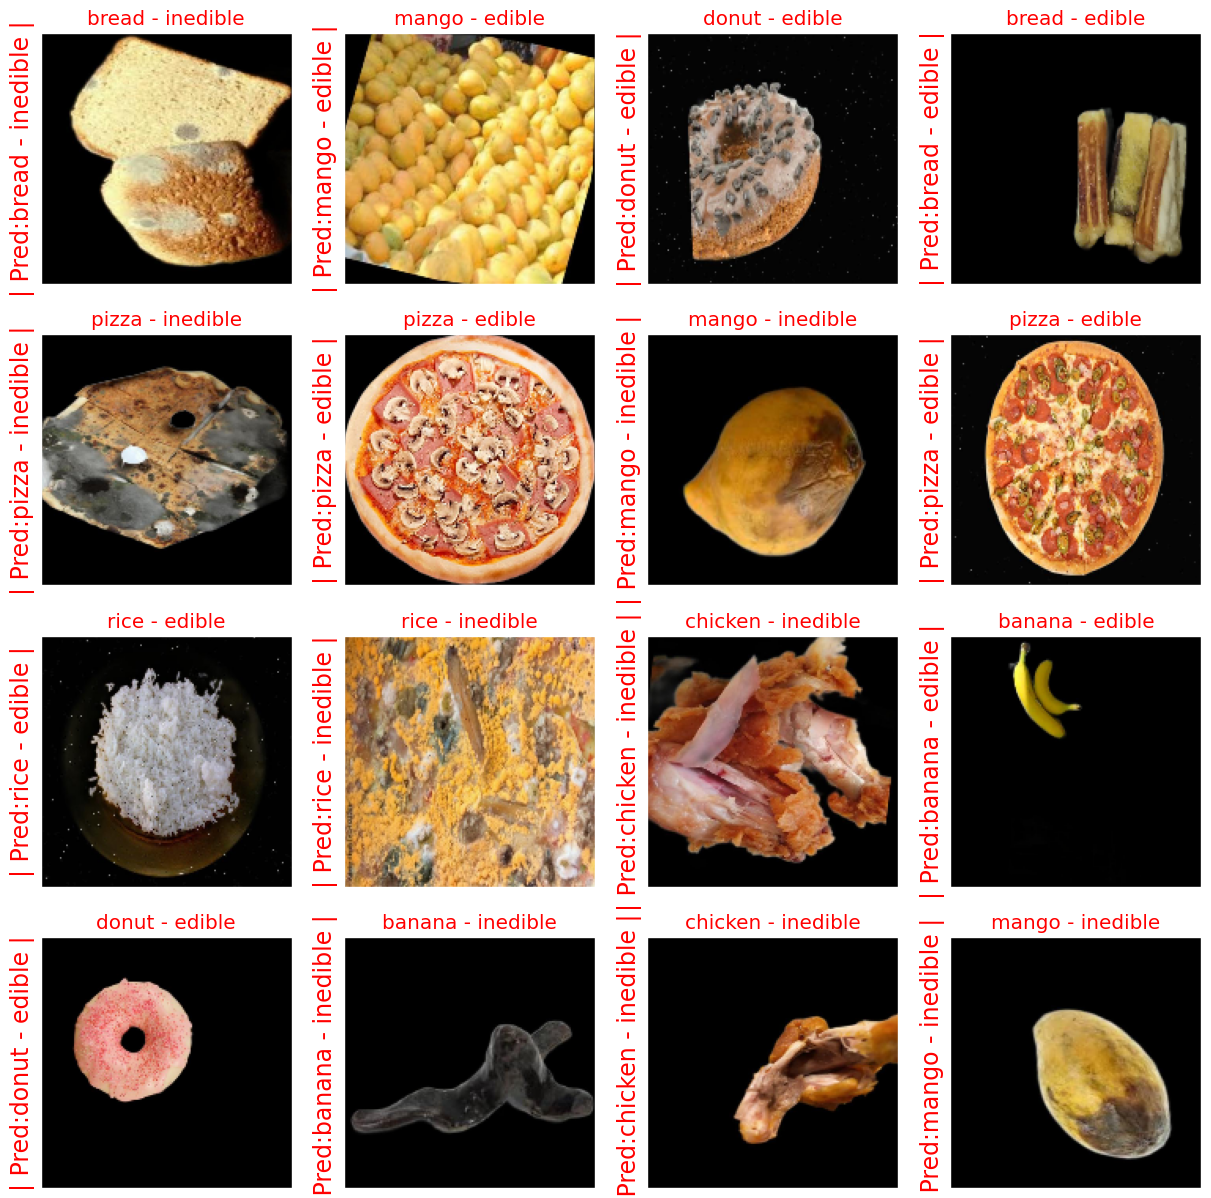

In [32]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if '-edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [50]:
file_path = "/kaggle/input/foodition-test/foodition-test/"
files = os.listdir(file_path)
data = {}

for col in files:
    os.chdir(os.path.join(file_path, col))
    data[col] = [i for i in os.listdir(os.getcwd()) if i.lower().endswith(('.jpg', '.jpeg', '.png'))]

class_list = ['banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible',
              'chicken - edible', 'chicken - inedible', 'donut - edible', 'donut - inedible',
              'mango - edible', 'mango - inedible', 'pizza - edible', 'pizza - inedible',
              'rice - edible', 'rice - inedible']

correct_predictions = 0
total_predictions = 0
incorrect_predictions = []

for col, images in data.items():
    for image_name in images:
        predict_path = os.path.join(file_path, col, image_name)

        img = image.load_img(predict_path, target_size=(160, 160))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalization

        # Assuming `model` is already defined or deployed
        # Perform prediction
        classes = model.predict(x, batch_size=1)

        predicted_class = class_list[np.argmax(classes[0])]
        if ('bener' in col and 'edible' not in predicted_class.lower()) or \
           ('jelek' in col and 'inedible' not in predicted_class.lower()):
            incorrect_predictions.append({
                'image_path': predict_path,
                'actual_class': col,
                'predicted_class': predicted_class
            })
        else: 
            correct_predictions += 1
        total_predictions += 1

print("Incorrect Predictions:")
for prediction in incorrect_predictions:
    print(f"Image: {prediction['image_path']}")
    print(f"Actual Class: {prediction['actual_class']}")
    print(f"Predicted Class: {prediction['predicted_class']}")
    print()
    
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

1/1 [==============================] - 0s 21ms/step
Incorrect Predictions:
Image: /kaggle/input/foodition-test/foodition-test/ayam-jelek/plate-of-half-eaten-chicken-wings-KWX3NE.jpg
Actual Class: ayam-jelek
Predicted Class: chicken - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/well_moldy-tmagArticle.jpg
Actual Class: roti-jelek
Predicted Class: bread - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/download (2).jpeg
Actual Class: roti-jelek
Predicted Class: bread - edible

Accuracy: 88.00%


In [ ]:
# model.save('d:\TITO\Documents\Deep-learning\\foodition-food-edible-classification\model_version\model8.h5')